In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO


In [2]:
import os
os.listdir()

['.DS_Store',
 'power_seller_score.csv',
 'uids.txt',
 '파워셀러 분석.ipynb',
 'powerSeller.xlsx',
 '.ipynb_checkpoints',
 'powerSeller_list.csv']

In [3]:
seller = pd.read_excel('powerSeller.xlsx', sheet_name='result', engine='openpyxl')

In [4]:
seller

,uid,category_name,category_count,21년3월 노출수,Unnamed: 4,Unnamed: 5
0,124,생활가구(침대/화장대 등),2,2307,NaN,NaN
1,254,타이어/휠,54,564,NaN,NaN
2,261,기타(색조메이크업),3,0,NaN,NaN
3,625,썬크림/썬로션,4,0,NaN,NaN
4,840,기타(주얼리/액세서리),42,1939,NaN,하루에 50
...,...,...,...,...,...,...
174924,12890761,스마트폰,4,0,NaN,NaN
174925,12896364,차량/오토바이,22,81075,NaN,NaN
174926,12897471,광고방/상점공지,1,106,NaN,NaN
174927,12901422,게임 타이틀,2,0,NaN,NaN


In [5]:
uid_list = seller.uid.astype(str)

In [6]:
uids = ','.join('\'' + str(u) + '\'' for u in uid_list)

In [7]:
import pickle
with open('uids.txt', 'wb') as f:
    pickle.dump(uids, f)

#### 파워셀러 점수 스코어링 피쳐들
- 라이브중인 상품 수
- 상품 등록 수
- 상품 등록 시간
- 업 사용 수

In [11]:
# 2020/06/08 기준
q = f'''
SELECT UID,
       count(CASE
                 WHEN status = 0 THEN 1
             END) AS live_cnt,
       count(DISTINCT id) AS p_cnt
FROM service1_quicket.product_info
WHERE UID IN ({uids})
GROUP BY 1
'''
products = pd.read_sql(q, con=bun_dw)

In [25]:
products

,uid,live_cnt,p_cnt
0,10513676,271,295
1,5004880,22,254
2,229244,111,8682
3,2345967,169,4249
4,1266155,483,1281
...,...,...,...
174887,7127299,0,1
174888,4345826,0,1
174889,10086560,0,1
174890,4837696,0,1


In [12]:
products.describe()

,uid,live_cnt,p_cnt
count,1.748920e+05,174892.000000,174892.000000
mean,4.106984e+06,23.382013,232.238616
std,2.893603e+06,244.137279,1107.072185
min,1.050000e+02,0.000000,1.000000
25%,1.951887e+06,0.000000,14.000000
50%,3.680164e+06,0.000000,45.000000
75%,5.550490e+06,4.000000,134.000000
max,1.290779e+07,38527.000000,70531.000000


In [15]:
q = f'''
SELECT UID,
       min(extract(hour
                   FROM create_date)) AS earliest,
       max(extract(hour
                   FROM create_date)) AS latest,
       latest - earliest AS diff
FROM service1_quicket.product_info
WHERE UID IN ({uids})
  AND create_date BETWEEN '2021-06-02 00:00:00' AND '2021-06-04 23:59:59'
GROUP BY 1
'''
upload = pd.read_sql(q, con=bun_dw)

In [16]:
upload.sort_values('diff', ascending=False)

,uid,earliest,latest,diff
0,61890,0,23,23
383,844711,0,23,23
330,321,0,23,23
2803,3672593,0,23,23
2799,10501657,0,23,23
...,...,...,...,...
2893,5369065,18,18,0
2894,9259850,20,20,0
2896,917087,23,23,0
2897,6871039,13,13,0


In [17]:
upload[((upload['diff'] >= 8) & (upload['diff'] <= 10)) | (upload['diff'] == 23)]

,uid,earliest,latest,diff
0,61890,0,23,23
10,10694113,0,23,23
16,7262988,0,23,23
33,943129,12,20,8
38,11537728,0,23,23
...,...,...,...,...
4694,2273894,12,22,10
4718,7940470,12,22,10
4812,1651139,14,23,9
4856,6542644,5,13,8


In [19]:
q = f'''
SELECT a.uid,
       a.top_category,
       a.p_cnt_in_top_category,
       b.distinct_category_cnt
FROM
  (SELECT UID,
          category AS top_category,
          p_cnt_in_category AS p_cnt_in_top_category
   FROM
     (SELECT UID,
             left(category_id, 3) AS category,
             count(DISTINCT id) AS p_cnt_in_category,
             row_number() OVER (PARTITION BY UID
                                ORDER BY count(DISTINCT id) DESC) AS ROW
      FROM service1_quicket.product_info
      WHERE UID IN ({uids}) AND status = 0
      GROUP BY 1,
               2)
   WHERE ROW = 1) a
JOIN
  (SELECT UID,
          count(DISTINCT left(category_id, 3)) AS distinct_category_cnt
   FROM service1_quicket.product_info
   WHERE UID IN ({uids})
   GROUP BY 1) b ON a.uid = b.uid
'''
category = pd.read_sql(q, con=bun_dw)

In [21]:
category.uid = category.uid.astype(str)

In [22]:
category.describe()

,p_cnt_in_top_category,distinct_category_cnt
count,74841.000000,74841.000000
mean,42.789220,5.712217
std,323.154769,3.336707
min,1.000000,1.000000
25%,2.000000,3.000000
50%,5.000000,5.000000
75%,16.000000,8.000000
max,38527.000000,19.000000


In [26]:
category[(category['distinct_category_cnt'] <= 3) & (category['p_cnt_in_top_category'] >= 10)].sort_values('p_cnt_in_top_category')

,uid,top_category,p_cnt_in_top_category,distinct_category_cnt
69642,8620134,600,10,2
41691,3892253,600,10,3
61858,6183055,800,10,3
41664,3882015,800,10,2
70995,10463143,700,10,2
...,...,...,...,...
58807,5842295,600,8127,1
20626,2164468,400,9064,1
43829,3996471,600,9936,1
70444,9503002,750,13393,3


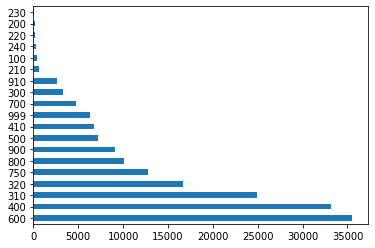

In [245]:
category.top_category.value_counts().plot(kind='barh')

In [27]:
#일주일간의 up plus
q = f'''
SELECT UID,
       count(*) AS up_plus_purchase_cnt,
       sum(qty) AS up_plus_cnt,
       sum(pay_point) AS pay_point,
       sum(pay_free) AS pay_free,
       sum(pay_point) + sum(pay_free) AS total_point
FROM service1_quicket.ad_up_plus
WHERE UID IN ({uids})
  AND created_at >= '2021-05-31'
  AND created_at <= '2021-06-04'
GROUP BY 1'''
up_plus = pd.read_sql(q, con=bun_dw)

In [28]:
up_plus.describe()

,uid,up_plus_purchase_cnt,up_plus_cnt,pay_point,pay_free,total_point
count,8.500000e+01,85.000000,85.000000,85.000000,85.000000,85.000000
mean,4.109964e+06,1.588235,81.588235,26027.000000,7164.764706,33191.764706
std,3.223615e+06,1.338924,128.418057,39830.315665,20265.090878,51171.495534
min,6.420000e+04,1.000000,5.000000,0.000000,0.000000,2500.000000
25%,1.494515e+06,1.000000,10.000000,0.000000,0.000000,4900.000000
50%,3.471351e+06,1.000000,50.000000,9900.000000,1200.000000,20000.000000
75%,6.284575e+06,2.000000,100.000000,38800.000000,5000.000000,40000.000000
max,1.256316e+07,9.000000,900.000000,192270.000000,170000.000000,360000.000000


In [29]:
# 일주일간 SA
q = f'''
SELECT UID,
       count(DISTINCT id) AS ad_id_cnt,
       sum(total_budget) AS total_budget,
       sum(paid_budget) AS total_paid_budget,
       sum(free_budget) AS total_free_budget
FROM service1_quicket.ad_set
WHERE created_at >= '2021-05-31'
  AND created_at <= '2021-06-04'
  AND UID IN ({uids})
GROUP BY 1
'''
sa = pd.read_sql(q, con=bun_dw)

In [30]:
sa.describe()

,uid,ad_id_cnt,total_budget,total_paid_budget,total_free_budget
count,3.330000e+02,333.000000,3.330000e+02,3.330000e+02,3.330000e+02
mean,4.731820e+06,3.078078,1.544404e+05,1.310248e+05,2.341566e+04
std,3.293469e+06,6.640958,5.249074e+05,4.079373e+05,1.398955e+05
min,1.469200e+04,1.000000,2.000000e+03,0.000000e+00,0.000000e+00
25%,2.288750e+06,1.000000,9.975000e+03,7.500000e+03,0.000000e+00
50%,3.978076e+06,1.000000,2.870000e+04,2.765000e+04,1.500000e+03
75%,6.963132e+06,3.000000,1.040000e+05,9.664000e+04,5.000000e+03
max,1.285182e+07,95.000000,7.450000e+06,5.238942e+06,2.211058e+06


In [31]:
q = f'''
SELECT content_owner AS UID,
       count(*) AS total_click_cnt,
       count(DISTINCT content_id) AS p_cnt,
       cast(total_click_cnt AS float)/p_cnt AS avg_click_cnt
FROM bun_log_db.app_event_type_view
WHERE content_owner IN ({uids})
  AND YEAR||MONTH||DAY = '20210607'
GROUP BY 1
'''
click = pd.read_sql(q, con=bun_dw)

In [32]:
q = f'''
SELECT content_owner AS uid,
       content_id AS pid,
       count(*) AS click_cnt
FROM bun_log_db.app_event_type_view
WHERE content_owner IN ({uids})
  AND YEAR||MONTH||DAY = '20210607'
GROUP BY 1, 2
'''
p_click = pd.read_sql(q, con=bun_dw)

In [33]:
idx = p_click.groupby('uid')['click_cnt'].transform(max) == p_click.click_cnt

In [34]:
which = p_click[idx]
mx = which[which['click_cnt'] >= 10].groupby(['uid'])['pid'].apply(lambda x: list(x)[0]).reset_index()

In [35]:
tmp_pids = which.sort_values('click_cnt', ascending=False)[:30].pid.tolist()

In [36]:
pids = ','.join('\'' + str(i) + '\'' for i in mx.pid)
q = f'''
select id, m_time
from service1_quicket.product_info
where id in ({pids})
'''
img = pd.read_sql(q, con=bun_dw)

In [37]:
img

,id,m_time
0,101402401,1618066987
1,101319216,1578635518
2,101394739,1556620928
3,101856760,1622899144
4,101054775,1613156027
...,...,...
8201,156054484,1623103099
8202,156171650,1623070529
8203,155781873,1623098033
8204,156108065,1623014594


In [38]:
def url(pid, m_time):
    hostname = "media.bunjang.co.kr"
    return 'https://{}/product/{}_1_{}_w292.jpg'.format(hostname, pid, m_time)

In [222]:
img[img['id'] == 100251310]['m_time'].values[0]

1613649818

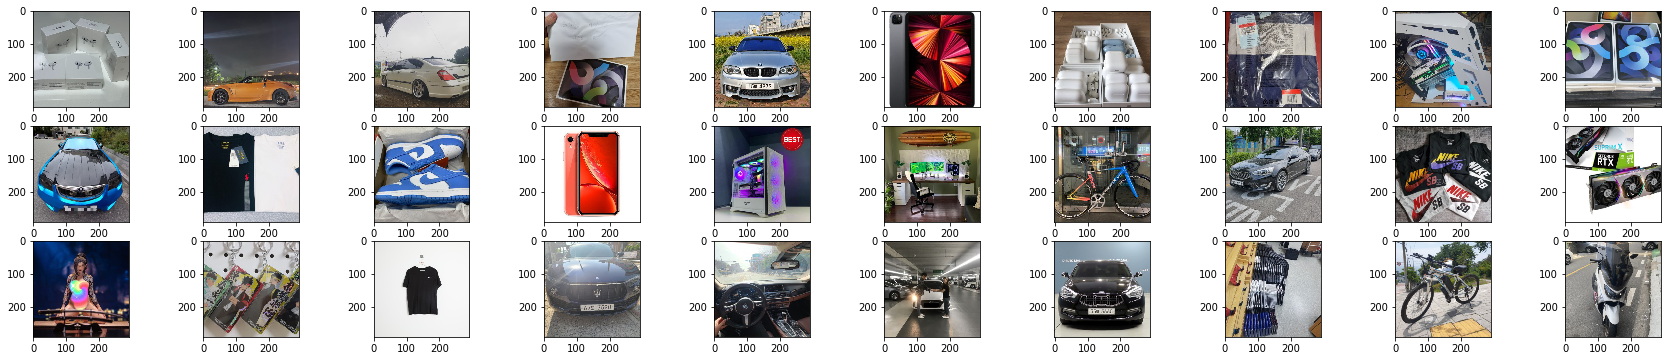

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from PIL import Image
import requests

plt.figure(figsize = (30, 6))

for i in range(len(tmp_pids)):
    pid = tmp_pids[i]
    im = Image.open(requests.get(url(pid, img[img['id'] == int(pid)]['m_time'].values[0]), stream=True).raw)
    plt.subplot(3, 10, i + 1)
    plt.imshow(im)

In [40]:
q = f'''
SELECT content_owner AS UID,
       count(*) AS total_imp_cnt,
       count(DISTINCT content_id) AS p_cnt,
       cast(total_imp_cnt AS float)/p_cnt AS avg_imp_cnt
FROM bun_log_db.app_event_type_impression
WHERE content_owner IN ({uids})
  AND YEAR||MONTH||DAY = '20210607'
GROUP BY 1
'''
imp = pd.read_sql(q, con=bun_dw)

In [41]:
q = f'''
SELECT id AS UID,
       favorite_count AS follower_cnt,
       review_count,
       grade
FROM service1_quicket.user_
WHERE id IN ({uids})
'''
user = pd.read_sql(q, con=bun_dw)

In [42]:
user.describe()

,uid,follower_cnt,review_count,grade
count,1.749280e+05,174928.000000,174928.000000,174928.000000
mean,4.107315e+06,77.339723,16.509558,157.274547
std,2.893887e+06,463.386926,74.553370,722.376873
min,1.050000e+02,-111.000000,0.000000,0.000000
25%,1.952063e+06,1.000000,0.000000,0.000000
50%,3.680238e+06,4.000000,2.000000,12.000000
75%,5.550857e+06,25.000000,10.000000,91.000000
max,1.290779e+07,29489.000000,12319.000000,119112.000000


### 모든 테이블 JOIN

In [43]:
tables = [products, upload, category, up_plus, sa, click, imp, user]
for t in tables:
    t['uid'] = t['uid'].astype(str)

In [44]:
df = pd.merge(products, upload, on='uid', how='outer')
df = pd.merge(df, category , on='uid', how='outer')
df = pd.merge(df, up_plus, on='uid', how='outer')
df = pd.merge(df, sa, on='uid', how='outer')
df = pd.merge(df, user, on='uid', how='outer')

In [45]:
click.uid = click.uid.astype(str)
imp.uid = imp.uid.astype(str)

cm = pd.merge(click, imp, on='uid', how='outer')

In [46]:
df = pd.merge(df, cm, on='uid', how='outer')

In [47]:
df

,uid,live_cnt,p_cnt,earliest,latest,diff,top_category,p_cnt_in_top_category,distinct_category_cnt,up_plus_purchase_cnt,...,total_free_budget,follower_cnt,review_count,grade,total_click_cnt,p_cnt_x,avg_click_cnt,total_imp_cnt,p_cnt_y,avg_imp_cnt
0,1349737,0.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,21.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN
1,5811350,7.0,226.0,NaN,NaN,NaN,910,7.0,5.0,NaN,...,NaN,51.0,57.0,506.0,21.0,4.0,5.250000,469.0,7.0,67.000000
2,89926,5276.0,28207.0,13.0,21.0,8.0,310,4959.0,16.0,NaN,...,3000.0,4173.0,1117.0,11066.0,1281.0,664.0,1.929217,45301.0,6238.0,7.262103
3,5681606,0.0,10119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2026.0,359.0,3335.0,NaN,NaN,NaN,NaN,NaN,NaN
4,386269,1084.0,15752.0,14.0,15.0,1.0,320,746.0,9.0,NaN,...,NaN,3347.0,409.0,3900.0,884.0,296.0,2.986486,20824.0,1698.0,12.263840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174924,7533710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,359.0,68.0,631.0,NaN,NaN,NaN,NaN,NaN,NaN
174925,7495995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
174926,9077688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2078.0,236.0,2264.0,NaN,NaN,NaN,NaN,NaN,NaN
174927,199284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,201.0,72.0,699.0,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df.columns

Index(['uid', 'live_cnt', 'p_cnt', 'earliest', 'latest', 'diff',
       'top_category', 'p_cnt_in_top_category', 'distinct_category_cnt',
       'up_plus_purchase_cnt', 'up_plus_cnt', 'pay_point', 'pay_free',
       'total_point', 'ad_id_cnt', 'total_budget', 'total_paid_budget',
       'total_free_budget', 'follower_cnt', 'review_count', 'grade',
       'total_click_cnt', 'p_cnt_x', 'avg_click_cnt', 'total_imp_cnt',
       'p_cnt_y', 'avg_imp_cnt'],
      dtype='object')

In [ ]:
df = df.fillna(0)

### SCORING

In [98]:
from sklearn.preprocessing import MinMaxScaler
cols = ['uid', 'live_cnt', 'p_cnt', 
        'up_plus_purchase_cnt', 'up_plus_cnt', 'total_point', 
        'ad_id_cnt', 'total_budget', 
        'follower_cnt', 'review_count', 'grade', 
        'total_click_cnt', 'avg_click_cnt', 'total_imp_cnt', 'avg_imp_cnt']
s = df[cols]

In [99]:
import numpy as np
s['if_work_hr'] = np.where(((df['diff']>=8) & (df['diff'] <= 10)) | (df['diff'] == 23), 1, 0)
s['if_category'] = np.where((df['p_cnt_in_top_category'] >= 10) & (df['distinct_category_cnt'] <= 3), 1, 0)

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
cols = ['live_cnt', 'p_cnt', 
        'up_plus_purchase_cnt', 'up_plus_cnt', 'total_point', 
        'ad_id_cnt', 'total_budget', 
        'follower_cnt', 'review_count', 'grade', 
        'total_click_cnt', 'avg_click_cnt', 'total_imp_cnt', 'avg_imp_cnt']
s[cols] = MinMaxScaler().fit_transform(s[cols])

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [101]:
s

,uid,live_cnt,p_cnt,up_plus_purchase_cnt,up_plus_cnt,total_point,ad_id_cnt,total_budget,follower_cnt,review_count,grade,total_click_cnt,avg_click_cnt,total_imp_cnt,avg_imp_cnt,if_work_hr,if_category
0,1349737,0.000000,0.000851,0.0,0.0,0.0,0.000000,0.000000,0.004020,0.001705,0.001679,0.000000,0.000000,0.000000,0.000000,0,0
1,5811350,0.000182,0.003204,0.0,0.0,0.0,0.000000,0.000000,0.005473,0.004627,0.004248,0.001459,0.010649,0.001396,0.005388,0,0
2,89926,0.136943,0.399923,0.0,0.0,0.0,0.010526,0.005369,0.144730,0.090673,0.092904,0.089026,0.003913,0.134809,0.000584,1,0
3,5681606,0.000000,0.143469,0.0,0.0,0.0,0.000000,0.000000,0.072196,0.029142,0.027999,0.000000,0.000000,0.000000,0.000000,0,0
4,386269,0.028136,0.223334,0.0,0.0,0.0,0.000000,0.000000,0.116824,0.033201,0.032742,0.061436,0.006058,0.061969,0.000986,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174924,7533710,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.015878,0.005520,0.005298,0.000000,0.000000,0.000000,0.000000,0,0
174925,7495995,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.003818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
174926,9077688,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.073953,0.019157,0.019007,0.000000,0.000000,0.000000,0.000000,0,0
174927,199284,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.010541,0.005845,0.005868,0.000000,0.000000,0.000000,0.000000,0,0


In [102]:
s.columns

Index(['uid', 'live_cnt', 'p_cnt', 'up_plus_purchase_cnt', 'up_plus_cnt',
       'total_point', 'ad_id_cnt', 'total_budget', 'follower_cnt',
       'review_count', 'grade', 'total_click_cnt', 'avg_click_cnt',
       'total_imp_cnt', 'avg_imp_cnt', 'if_work_hr', 'if_category'],
      dtype='object')

In [103]:
def score(live_cnt, p_cnt, up_plus_purchase_cnt, up_plus_cnt, total_point, ad_id_cnt, total_budget, follower_cnt, review_count, grade, avg_click_cnt, avg_imp_cnt, if_work_hr, if_category):
    sc = s['live_cnt'] * live_cnt \
    + s['p_cnt'] * p_cnt \
    + s['up_plus_purchase_cnt'] * up_plus_purchase_cnt \
    + s['up_plus_cnt'] * up_plus_cnt \
    + s['total_point'] * total_point \
    + s['ad_id_cnt'] * ad_id_cnt \
    + s['total_budget'] * total_budget \
    + s['follower_cnt'] * follower_cnt \
    + s['review_count'] * review_count \
    + s['grade'] * grade \
    + s['avg_click_cnt'] * avg_click_cnt \
    + s['avg_imp_cnt'] * avg_imp_cnt \
    + s['if_work_hr'] * if_work_hr \
    + s['if_category'] * if_category
    return sc

In [108]:
# s['score'] = score(5, 1, 2, 3, 3, 6, 3, 4, 4, 3, 5, 2, 5, 5)
features = ['live_cnt', 'p_cnt', 'up_plus_purchase_cnt', 'up_plus_cnt', 'total_point', 'ad_id_cnt', 'total_budget', 'follower_cnt', 'review_count', 'grade', 'avg_click_cnt', 'avg_imp_cnt', 'if_work_hr', 'if_category']
s.sort_values('score', ascending=False)[['uid', 'score'] + features][:30]

,uid,score,live_cnt,p_cnt,up_plus_purchase_cnt,up_plus_cnt,total_point,ad_id_cnt,total_budget,follower_cnt,review_count,grade,avg_click_cnt,avg_imp_cnt,if_work_hr,if_category
16860,6972746,18.418174,0.002570,0.046717,0.000000,0.000000,0.000000,1.000000,0.407221,0.127264,0.059177,0.059306,0.040287,0.005916,1,1
1774,6310647,13.188414,0.031277,0.036041,0.222222,0.222222,0.222222,0.157895,0.012520,0.020338,0.016722,0.017303,0.005470,0.002891,1,1
6848,592959,11.870952,0.003348,0.039968,0.111111,0.111111,0.111111,0.052632,0.025369,0.853041,1.000000,1.000000,0.022268,0.004978,0,0
7034,66620,11.660639,0.000415,0.005260,0.111111,0.111111,0.111111,0.094737,1.000000,0.109595,0.060070,0.060859,0.239731,0.068051,0,1
459,6965817,11.531981,0.000649,0.024741,0.111111,0.055556,0.055556,0.010526,0.023087,0.050338,0.049436,0.050348,0.052409,0.001918,1,1
6608,9877273,11.515694,0.000519,0.033687,0.111111,0.022222,0.024722,0.000000,0.000000,0.074932,0.097167,0.099343,0.025152,0.002083,1,1
66452,11771508,11.281360,0.000545,0.000681,0.000000,0.000000,0.000000,0.178947,0.005431,0.003953,0.000162,0.000168,0.021245,0.032395,1,1
14252,3059607,11.087934,0.001116,0.035077,0.000000,0.000000,0.000000,0.000000,0.000000,0.104966,0.080851,0.078220,0.012170,0.004248,1,1
12644,3511813,10.816146,0.000597,0.081893,0.000000,0.000000,0.000000,0.000000,0.000000,0.097230,0.035636,0.035504,0.017475,0.002957,1,1
8532,3947717,10.813748,0.010927,0.070891,0.000000,0.000000,0.000000,0.515789,0.128505,0.192230,0.146846,0.142958,0.074456,0.025256,1,0


In [109]:
s.sort_values('score', ascending=False)[['uid', 'score'] + features].to_csv("power_seller_score.csv", index=False)